**Workshop**

Backtest your mpt portfolio

## Import library

In [25]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# pip install pyfolio, PyPortfolioOpt
import pyfolio as pf
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA, plotting

## Import Data

In [26]:
'''
let's get ETF data
SPY = S&P 500 ETF
QQQ = Nasdaq ETF
CQQQ = kind of China Nasdaq ETF
IEF = 7-10y bond ETF 
TMF = 20+ y bond 3x ETF
''' 
data = yf.download(tickers = "SPY QQQ CQQQ IEF TMF", period ='10y' )

[*********************100%***********************]  5 of 5 completed


In [27]:
df = data.Close.fillna(method='ffill')

In [28]:
weekly = df.resample('W-FRI').last().iloc[:-1]

In [29]:
df.pct_change().cov()*252

,CQQQ,IEF,QQQ,SPY,TMF
CQQQ,0.093869,-0.002835,0.038188,0.028699,-0.019509
IEF,-0.002835,0.003843,-0.002284,-0.002514,0.024057
QQQ,0.038188,-0.002284,0.044568,0.034175,-0.018491
SPY,0.028699,-0.002514,0.034175,0.030468,-0.020530
TMF,-0.019509,0.024057,-0.018491,-0.020530,0.182018


In [30]:
risk_models.sample_cov(df)

,CQQQ,IEF,QQQ,SPY,TMF
CQQQ,0.093869,-0.002835,0.038188,0.028699,-0.019509
IEF,-0.002835,0.003843,-0.002284,-0.002514,0.024057
QQQ,0.038188,-0.002284,0.044568,0.034175,-0.018491
SPY,0.028699,-0.002514,0.034175,0.030468,-0.020530
TMF,-0.019509,0.024057,-0.018491,-0.020530,0.182018


In [31]:
weekly.pct_change().cov()*52

,CQQQ,IEF,QQQ,SPY,TMF
CQQQ,0.082111,-0.001718,0.030318,0.022666,-0.011225
IEF,-0.001718,0.003690,-0.000802,-0.001343,0.022495
QQQ,0.030318,-0.000802,0.036088,0.028887,-0.006192
SPY,0.022666,-0.001343,0.028887,0.027408,-0.009986
TMF,-0.011225,0.022495,-0.006192,-0.009986,0.163877


In [32]:
mu = expected_returns.mean_historical_return(df)
S = weekly.pct_change().cov()*52
ef = EfficientFrontier(mu, S, weight_bounds=(0.05, 0.5)) #ลงขั้นต่ำ 5% ต่อ 1 assets, cap 50%
# ef = EfficientFrontier(mu, S)

In [33]:
raw_weight = ef.max_sharpe()
cleaned_weight = ef.clean_weights()
cleaned_weight

OrderedDict([('CQQQ', 0.05),
             ('IEF', 0.05),
             ('QQQ', 0.5),
             ('SPY', 0.35),
             ('TMF', 0.05)])

In [34]:
selected = [k for k in cleaned_weight if cleaned_weight[k] > 0]
selected_weight = [cleaned_weight[k] for k in cleaned_weight if cleaned_weight[k] > 0]

In [35]:
selected

['CQQQ', 'IEF', 'QQQ', 'SPY', 'TMF']

In [36]:
selected_weight

[0.05, 0.05, 0.5, 0.35, 0.05]

In [37]:
port = df[selected]
port_ret = port.pct_change()

port_ret

,CQQQ,IEF,QQQ,SPY,TMF
Date,,,,,
2012-12-24,NaN,NaN,NaN,NaN,NaN
2012-12-26,0.013495,0.000651,-0.008760,-0.004215,0.010829
2012-12-27,0.000459,0.002045,-0.001550,-0.001340,0.008950
2012-12-28,0.001377,0.002319,-0.009627,-0.010808,0.018414
2012-12-31,0.022915,-0.005275,0.021166,0.016996,-0.052263
...,...,...,...,...,...
2022-12-19,-0.008106,-0.008113,-0.016408,-0.008480,-0.052905
2022-12-20,-0.014709,-0.007259,-0.000778,0.001368,-0.060241
2022-12-21,0.020142,0.001236,0.014506,0.014952,0.004662


In [38]:
initial_amount = 1000000 # assume no fees
port_value = (port_ret+1).cumprod() * selected_weight * initial_amount

port_value

,CQQQ,IEF,QQQ,SPY,TMF
Date,,,,,
2012-12-24,NaN,NaN,NaN,NaN,NaN
2012-12-26,50674.734571,50032.551942,4.956201e+05,348524.747965,50541.467408
2012-12-27,50698.001739,50134.859061,4.948517e+05,348057.583570,50993.834570
2012-12-28,50767.798807,50251.116505,4.900876e+05,344295.732149,51932.830578
2012-12-31,51931.130602,49986.049674,5.004610e+05,350147.517700,49218.643292
...,...,...,...,...,...
2022-12-19,99651.005787,45484.561297,2.072768e+06,934365.932222,25030.844404
2022-12-20,98185.205241,45154.390581,2.071154e+06,935644.519002,23522.961707
2022-12-21,100162.865741,45210.195432,2.101199e+06,949634.689491,23632.625761


In [39]:
port_value['total'] = port_value.sum(axis=1)
port_value.iloc[0, -1] = initial_amount # 1st row, last col (total  ) define 'initial amount'
port_value['port_return'] = port_value['total'].pct_change()

port_value

,CQQQ,IEF,QQQ,SPY,TMF,total,port_return
Date,,,,,,,
2012-12-24,NaN,NaN,NaN,NaN,NaN,1.000000e+06,NaN
2012-12-26,50674.734571,50032.551942,4.956201e+05,348524.747965,50541.467408,9.953936e+05,-0.004606
2012-12-27,50698.001739,50134.859061,4.948517e+05,348057.583570,50993.834570,9.947360e+05,-0.000661
2012-12-28,50767.798807,50251.116505,4.900876e+05,344295.732149,51932.830578,9.873351e+05,-0.007440
2012-12-31,51931.130602,49986.049674,5.004610e+05,350147.517700,49218.643292,1.001744e+06,0.014594
...,...,...,...,...,...,...,...
2022-12-19,99651.005787,45484.561297,2.072768e+06,934365.932222,25030.844404,3.177300e+06,-0.014012
2022-12-20,98185.205241,45154.390581,2.071154e+06,935644.519002,23522.961707,3.173661e+06,-0.001145
2022-12-21,100162.865741,45210.195432,2.101199e+06,949634.689491,23632.625761,3.219839e+06,0.014550


## Pyfolio 

In [40]:
port_value.index = pd.to_datetime(port_value.index).tz_localize('UTC')

port_value.index

DatetimeIndex(['2012-12-24 00:00:00+00:00', '2012-12-26 00:00:00+00:00',
               '2012-12-27 00:00:00+00:00', '2012-12-28 00:00:00+00:00',
               '2012-12-31 00:00:00+00:00', '2013-01-02 00:00:00+00:00',
               '2013-01-03 00:00:00+00:00', '2013-01-04 00:00:00+00:00',
               '2013-01-07 00:00:00+00:00', '2013-01-08 00:00:00+00:00',
               ...
               '2022-12-12 00:00:00+00:00', '2022-12-13 00:00:00+00:00',
               '2022-12-14 00:00:00+00:00', '2022-12-15 00:00:00+00:00',
               '2022-12-16 00:00:00+00:00', '2022-12-19 00:00:00+00:00',
               '2022-12-20 00:00:00+00:00', '2022-12-21 00:00:00+00:00',
               '2022-12-22 00:00:00+00:00', '2022-12-23 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2519, freq=None)

### Returns

In [41]:
returns = port_value['port_return']
returns

Date
2012-12-24 00:00:00+00:00         NaN
2012-12-26 00:00:00+00:00   -0.004606
2012-12-27 00:00:00+00:00   -0.000661
2012-12-28 00:00:00+00:00   -0.007440
2012-12-31 00:00:00+00:00    0.014594
                               ...   
2022-12-19 00:00:00+00:00   -0.014012
2022-12-20 00:00:00+00:00   -0.001145
2022-12-21 00:00:00+00:00    0.014550
2022-12-22 00:00:00+00:00   -0.020384
2022-12-23 00:00:00+00:00    0.002480
Name: port_return, Length: 2519, dtype: float64

In [42]:
port_value.columns

Index(['CQQQ', 'IEF', 'QQQ', 'SPY', 'TMF', 'total', 'port_return'], dtype='object')

### Positions

In [43]:
positions = port_value.iloc[:, :-2]
positions['cash'] = 0
positions.iloc[0, -1] = initial_amount

positions

/var/folders/6t/_xyw489d5jnd7011n2m_x_ch0000gn/T/ipykernel_38243/285217486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions['cash'] = 0


,CQQQ,IEF,QQQ,SPY,TMF,cash
Date,,,,,,
2012-12-24 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1000000
2012-12-26 00:00:00+00:00,50674.734571,50032.551942,4.956201e+05,348524.747965,50541.467408,0
2012-12-27 00:00:00+00:00,50698.001739,50134.859061,4.948517e+05,348057.583570,50993.834570,0
2012-12-28 00:00:00+00:00,50767.798807,50251.116505,4.900876e+05,344295.732149,51932.830578,0
2012-12-31 00:00:00+00:00,51931.130602,49986.049674,5.004610e+05,350147.517700,49218.643292,0
...,...,...,...,...,...,...
2022-12-19 00:00:00+00:00,99651.005787,45484.561297,2.072768e+06,934365.932222,25030.844404,0
2022-12-20 00:00:00+00:00,98185.205241,45154.390581,2.071154e+06,935644.519002,23522.961707,0
2022-12-21 00:00:00+00:00,100162.865741,45210.195432,2.101199e+06,949634.689491,23632.625761,0


/Users/puwa/opt/anaconda3/envs/investic/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/puwa/opt/anaconda3/envs/investic/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/puwa/opt/anaconda3/envs/investic/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/puwa/opt/anaconda3/envs/investic/lib/python3.9/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future ve

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.47,2021-12-27,2022-10-14,NaT,NaN
1,26.91,2020-02-19,2020-03-23,2020-06-08,79
2,21.06,2018-08-29,2018-12-24,2019-04-17,166
3,13.44,2015-12-01,2016-02-11,2016-07-11,160
4,12.60,2015-04-24,2015-08-25,2015-11-03,138


/Users/puwa/opt/anaconda3/envs/investic/lib/python3.9/site-packages/pyfolio/timeseries.py:1141: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

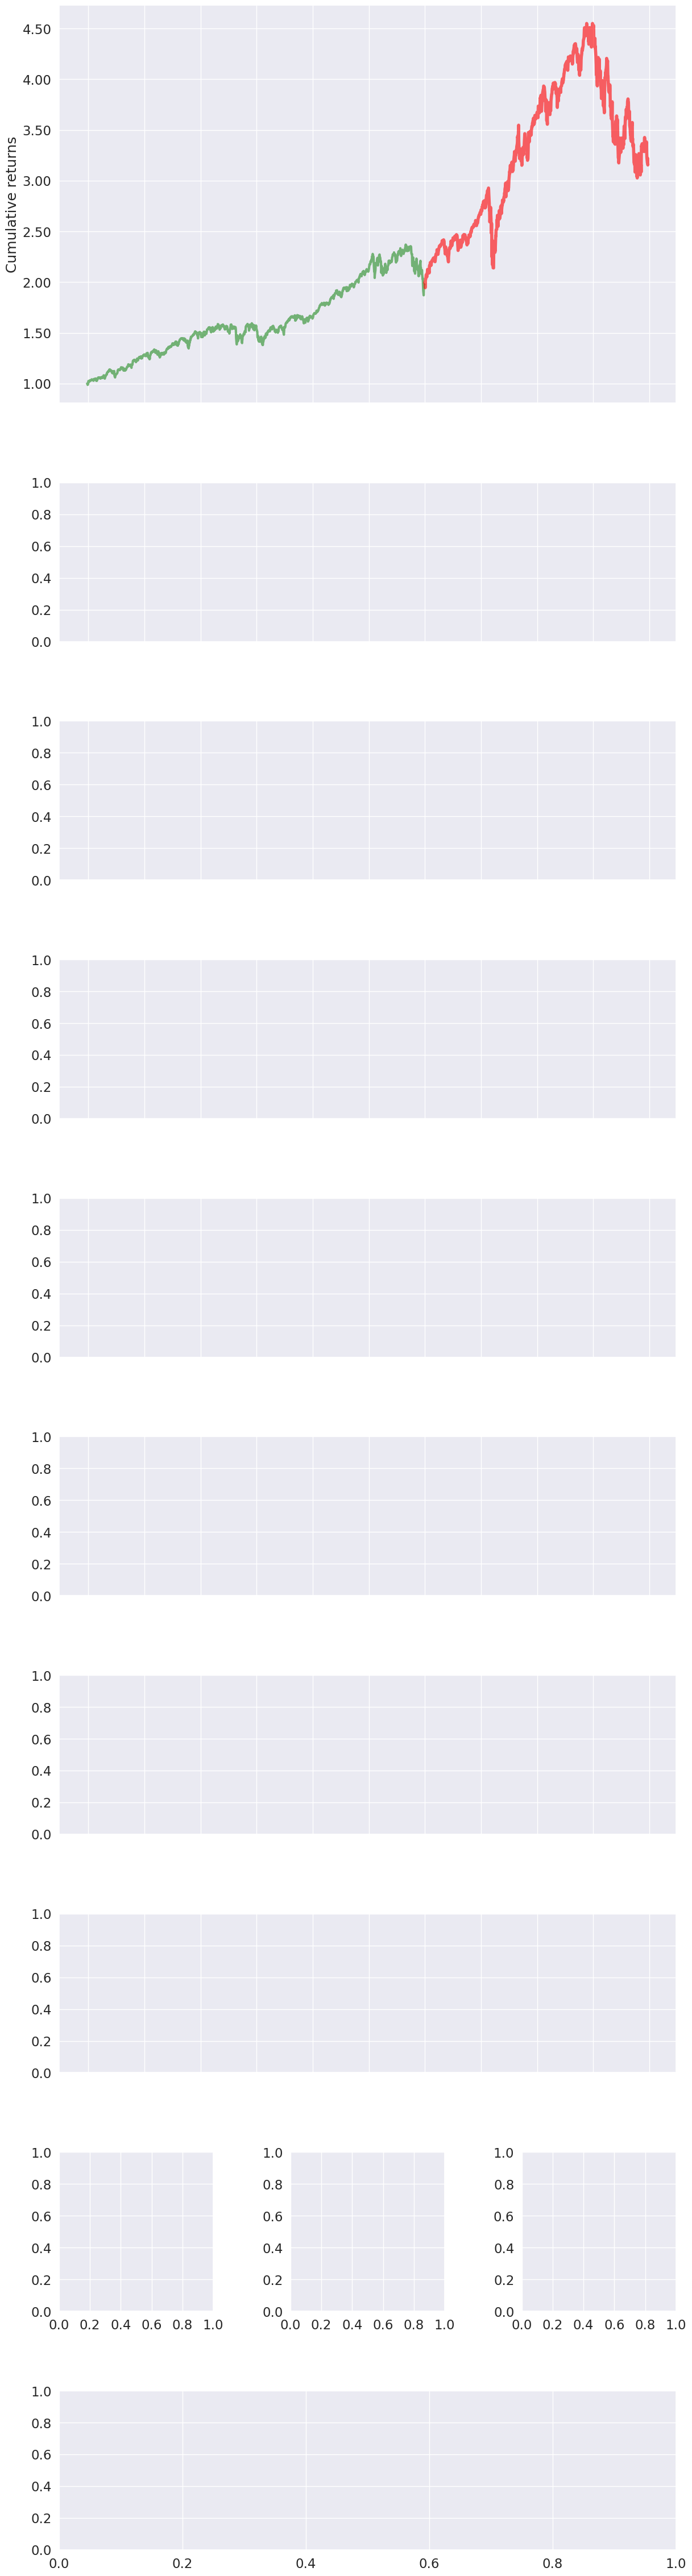

In [44]:
pf.create_returns_tear_sheet(   returns, live_start_date='2018-12-31')